In [33]:
import torch 
import hydra
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.base_image_policy import BaseImagePolicy
import dill
import matplotlib.pyplot as plt

import zarr
import numpy as np

from diffusion_policy.dataset.real_image_dataset import real_data_to_replay_buffer

# load checkpoint
ckpt_path = "/home/zheyu/RoboSaGA/experiments/robosaga/archive/epoch=0550-train_loss=0.004.ckpt"
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)

# hacks for method-specific setup.
action_offset = 0
delta_action = False
if 'diffusion' in cfg.name:
    # diffusion model
    policy: BaseImagePolicy
    policy = workspace.model
    if cfg.training.use_ema:
        policy = workspace.ema_model

    device = torch.device('cuda')
    policy.eval().to(device)

    # set inference params
    policy.num_inference_steps = 100 # DDIM inference iterations
    # print( policy.horizon, policy.n_obs_steps)
    # policy.n_action_steps = policy.horizon - policy.n_obs_steps + 1

# 
data_path = 'data/green_pnp.zarr'
store = zarr.DirectoryStore(data_path)
src_root = zarr.group(store=store, overwrite=False)
#
data = src_root['data']
meta = src_root['meta']

# #
# data
#  ├── action (24703, 7) float32
#  ├── ee_rgb_camera (24703, 84, 84, 3) float32
#  ├── front_rgb_camera (24703, 3, 84, 84) float32
#  └── robot_state (24703, 16) float32

ee_rgb_camera = data['ee_rgb_camera']
front_rgb_camera = data['front_rgb_camera']
robot_state = data['robot_state']
action = data['action']

#
episode_slices = meta['episode_ends']

def get_episode(idx):
    if idx == 0:
        start = 0
    else:
        start = episode_slices[idx-1]
    end = episode_slices[idx]
    ee_rgb_camera_ = np.array(ee_rgb_camera[start:end]).transpose(0, 3, 1, 2)/255.0
    front_rgb_camera_ = np.array(front_rgb_camera[start:end])/255.0
    robot_state_ = np.array(robot_state[start:end])
    action_ = np.array(action[start:end])
    return ee_rgb_camera_, front_rgb_camera_, robot_state_, action_


def get_data(idx, obs_len = 2, pred_len = 8):
    i_th_episode = get_episode(idx)
    ee_rgb_camera_, front_rgb_camera_, robot_state_, action_ = i_th_episode
    rand_start = np.random.randint(0, len(ee_rgb_camera_)-obs_len-pred_len)
    
    ground_truth = torch.tensor(action_[rand_start+obs_len:rand_start+obs_len+pred_len]).unsqueeze(0).to('cuda')
    obs_dict =   {
        'ee_rgb_camera': torch.tensor(ee_rgb_camera_[rand_start:rand_start+obs_len]).unsqueeze(0).to('cuda'),
        'front_rgb_camera': torch.tensor(front_rgb_camera_[rand_start:rand_start+obs_len]).unsqueeze(0).to('cuda'),
        'robot_state': torch.tensor(robot_state_[rand_start:rand_start+obs_len]).unsqueeze(0).to('cuda')
    }
    return obs_dict, ground_truth
        


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot_state']
using obs modality: rgb with keys: ['ee_rgb_camera', 'front_rgb_camera']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Diffusion params: 2.560027e+08
Vision params: 2.239418e+07


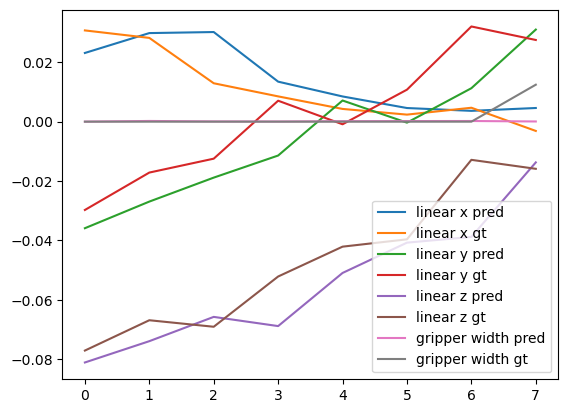

In [42]:
episode_idx = 0

obs_dict, ground_truth = get_data(episode_idx)
pred = policy.predict_action(obs_dict)['action']

pred = pred.squeeze(0).cpu().detach().numpy()
ground_truth = ground_truth.squeeze(0).cpu().detach().numpy()

ee_vel_pred = pred[:, :6]
gripper_width_pred = pred[:, 6]

ee_vel_gt = ground_truth[:, :6]
gripper_width_gt = ground_truth[:, 6]


linear_vel_pred = ee_vel_pred[:, :3]
angular_vel_pred = ee_vel_pred[:, 3:]

linear_vel_gt = ee_vel_gt[:, :3]
angular_vel_gt = ee_vel_gt[:, 3:]

# # plot the actions

plt.figure()

plt.plot(linear_vel_pred[:, 0], label='linear x pred')
plt.plot(linear_vel_gt[:, 0], label='linear x gt')

plt.plot(linear_vel_pred[:, 1], label='linear y pred')
plt.plot(linear_vel_gt[:, 1], label='linear y gt')

plt.plot(linear_vel_pred[:, 2], label='linear z pred')
plt.plot(linear_vel_gt[:, 2], label='linear z gt')

plt.plot(gripper_width_pred, label='gripper width pred')
plt.plot(gripper_width_gt, label='gripper width gt')

plt.legend()